# Lecture 9 - HMMs and done

## 2021/05/28

## Gene 111

## Logistics

- Homework 6 due __Tuesday__ (Monday is a holiday)

- Homework regrades for 1-5 possible up until __Tuesday @ midnight__

- Last class

## CpG island detection


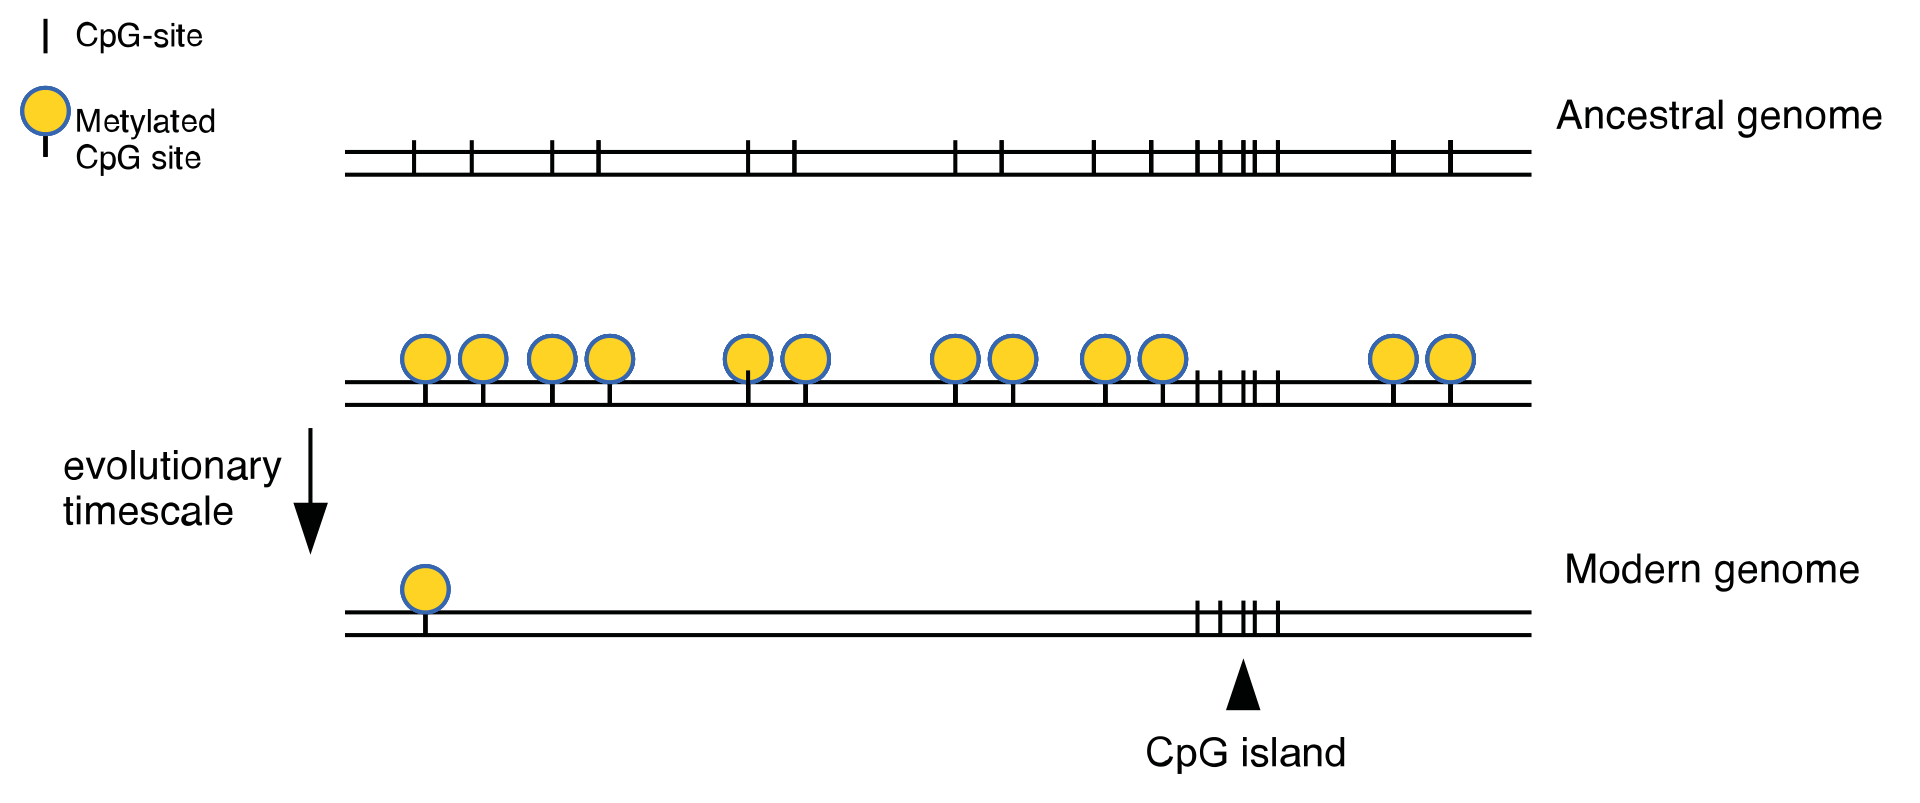
[Wikipedia](https://en.wikipedia.org/wiki/CpG_site#/media/File:Cpg_island_evolution.svg)

## Viterbi

For the "biased coin" (B) matrix cell circled below in red, we find the maximum probability using:
- The transition probability from each of the possible previous states combined with the probability in the cell from each of the previous states (red arrows)
- The emission probability for the observed symbol (in this case a heads, H)

$
probability(i,j) = probability(\pi = \text{biased coin}, j) = \max
\begin{cases} 
      \pi_{i_\text{fair },j-1} * transition_{\text{(fair to biased)}} * emission_{\text{ H } | \text{biased}} \\
      \pi_{i_\text{biased },j-1} * transition_{\text{(biased to biased)}} * emission_{\text{ H } | \text{biased}} \\
\end{cases}
\\
$

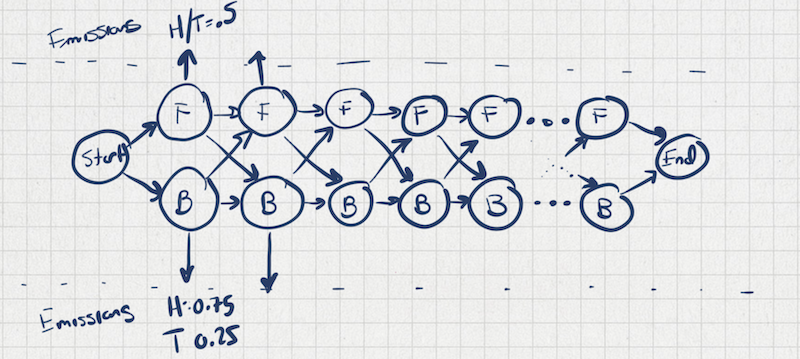


In addition, for the "fair coin" cell state (F) directly __above__ the highlighed cell, we compute:

$
probability(i,j) = probability(\pi = \text{fair coin}, j) = \max
\begin{cases} 
      \pi_{i_\text{fair },j-1} * transition_{\text{(fair to fair)}} * emission_{\text{ H } | \text{fair}} \\
      \pi_{i_\text{biased },j-1} * transition_{\text{(biased to fair)}} * emission_{\text{ H } | \text{fair}} \\
\end{cases}
\\
$

Notice how the transition and emission probabilty lookups change to match the state we're in and the states we're coming from. In both bases this column emits a heads (H), as that's the coin flip we observe in this step regardless of the underlying hidden state we're trying to predict.

In [1]:
# removed cell contents as it's the homework

## Traceback

Like what we saw in dynamic programming...

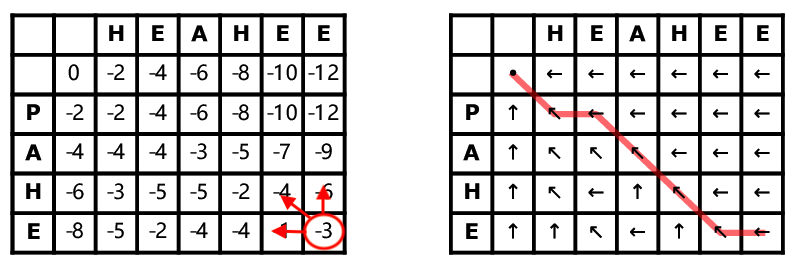

## Traceback

In [4]:
# find the maximal score in the final column
final_max = np.argmax([hmm_model[:,-1]])

# create a matrix to store the maximal path back through the HMM
state_path = np.zeros((len(chr21_9m_to_10m)),np.int64)

# We also want to know how many times we've transitioned between
# the two hidden states (we're curious..). Keep track of that here:
row_pointer = final_max
switch = 0

# how fill in the traceback matrix going from the end of the matrix
# to the begining (the final -1 step). We update which state (row) we got
# our best score from, and then move to the previous column using that
# row's trackback value.
for i in range(len(chr21_9m_to_10m)-1,0,-1):
    state_path[i] = row_pointer
    if hmm_model_traceaback[row_pointer,i] != row_pointer:
        switch += 1
    row_pointer = hmm_model_traceaback[row_pointer,i]

# print how many of each state (0 == CpG, 1 == not) we found
print(np.unique(state_path,return_counts=True))

# print how many times we switched between states
print("\nWe switched states: " + str(switch) + " times")

(array([0, 1]), array([ 76654, 923346]))

We switched states: 98 times


# Confusion matrix

In [10]:
confusion_matrix = np.zeros((2,2))

# make an array with a size matching our genome segment, with the
# default value being '1', or not a CpG base
truth_array = np.ones((len(chr21_9m_to_10m)),np.int64)

# fill in CpGs as '0's where our Bed file indicates
for x in cpg_pairs:
    if x[0]  > 9000000 and x[1] < 10000000:
        truth_array[x[0] - 9000000:x[1] - 9000000] = 0

# now compare the predicted state path and the truth array
# to compute a confusion matrix of our two outcomes vs truth
for i in range(0,len(chr21_9m_to_10m)):
    confusion_matrix[state_path[i],truth_array[i]] += 1

# print the resulting table
pretty_print( ["CpG","not"], ["True ","False"],confusion_matrix,pad=10,round_to=5)

     True      False
CpG    4881.0   71773.0
not      35.0  923311.0


## Assessment of our scoring results

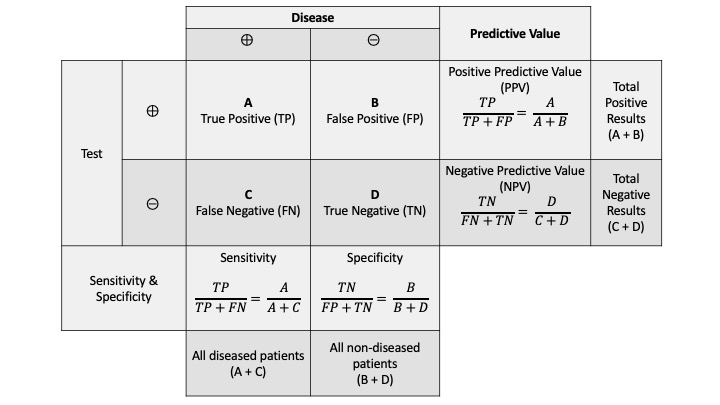

[Source](https://step1.medbullets.com/stats/101006/testing-and-screening)

## Assessment of our scoring results



In [11]:

print("\naccuracy : " + str((confusion_matrix[0,0]+confusion_matrix[1,1])/confusion_matrix.sum()))

print("\npositive predictive value (PPV): " + str(confusion_matrix[0,0]/(confusion_matrix[0,0]++confusion_matrix[0,1])))
print("\nnegative predictive value (NPV): " + str(confusion_matrix[1,1]/(confusion_matrix[1,0]++confusion_matrix[1,1])))
print("\nsensitivity: " + str(confusion_matrix[0,0]/(confusion_matrix[0,0]++confusion_matrix[1,0])))
print("\nspecificity: " + str(confusion_matrix[0,1]/(confusion_matrix[0,1]++confusion_matrix[1,1])))




accuracy : 0.928192

positive predictive value (PPV): 0.06367573773058158

negative predictive value (NPV): 0.9999620943828207

sensitivity: 0.9928803905614321

specificity: 0.07212757917924517


## More accurate models

Why would this be more effective?

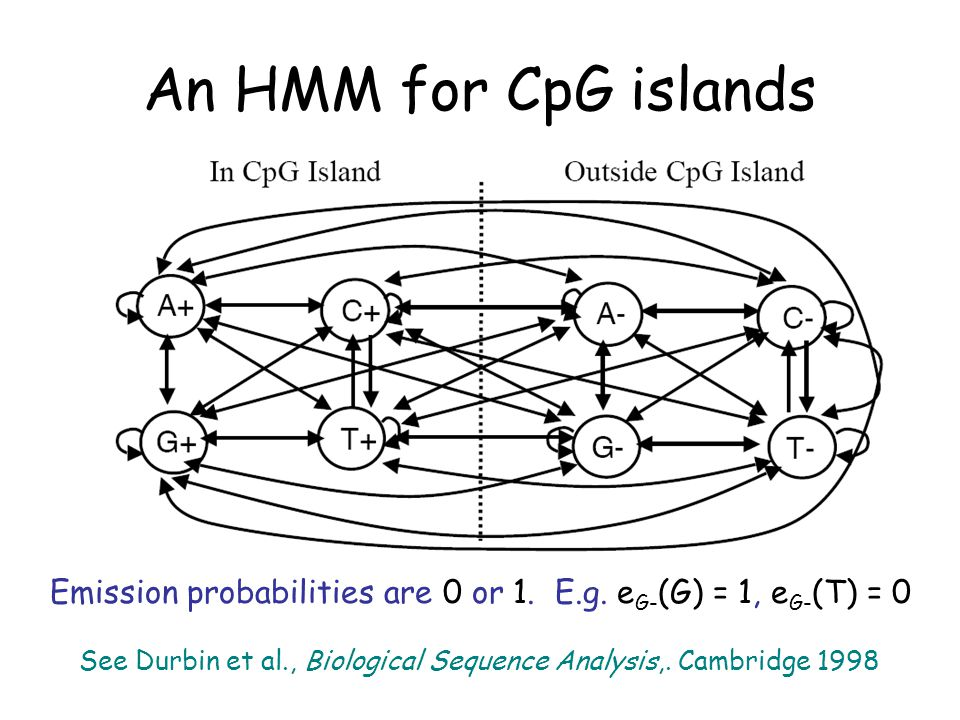

[Source](https://slideplayer.com/slide/4757291/)

## Learning parameters

In [14]:
pretty_print("ACGTN","ACGTN", emissions_global_normalized)

     A     C     G     T     N
A 0.084 0.044 0.059 0.066   0.0
C 0.063 0.044  0.01 0.059   0.0
G 0.052 0.037 0.044 0.044   0.0
T 0.055 0.051 0.063 0.085   0.0
N   0.0   0.0   0.0   0.0 0.142


In [15]:
pretty_print("ACGTN","ACGTN", cpg_only_emissions_normalized)

     A     C     G     T     N
A 0.025 0.042 0.059 0.017   0.0
C 0.054 0.126 0.101 0.062   0.0
G 0.052 0.117 0.121 0.046   0.0
T 0.012 0.057 0.057 0.031   0.0
N   0.0   0.0   0.0   0.0  0.02


In [16]:
pretty_print("CN", "CN", transition_props,pad=8,round_to=5)

       C       N
C  0.9999  0.0001
N   1e-05 0.99999


## Estimates when the parameters are already known - maximum likelihood 

When we have training data that we can segment, we can assign the transition probability to the maximum likelihood value $\pi_{kl} = \frac{\pi_{kl}}{\sum_{l`}{\pi_{kl`}}}$ 

And the emission probabilities E to $E_{k}(b) = \frac{E_{kl}}{\sum_{b'}{E_{k}(b')}}$

This is _essentially_* what we did in the previous lecture for the emission probabilities, though not for the transition probabilities. 

__What about if we don't have training data?__

## Baum-Welch and Viterbi training



- Often we don't have training data, or the training data we have is incomplete or faulty

- We want to jointly estimate the underlying state path while optimizing the parameters to our model

- There are two methods, Baum-Welch and 'Viterbi training' that fit into a wider class of methods called Expectation–maximization algorithms

- The big picture idea is to iteratively improve the model by using a set of parameters to find the best fit of the data and...

- Then to use that fit of the data to re-estimate the parameters

- Two common options, Baum-Welch and Viterbi training or Viterbi learning. We'll talk about Viterbi, but Baum-Welch is very related

## Viterbi training

- Given the transition and emission parameters, estimate the most probable path of $\pi$s for the training data set

- Given the most probable $\pi$ paths, re-estimate the parameters using equations above and goto step 1

- Repeat until convergence (what does that mean?)

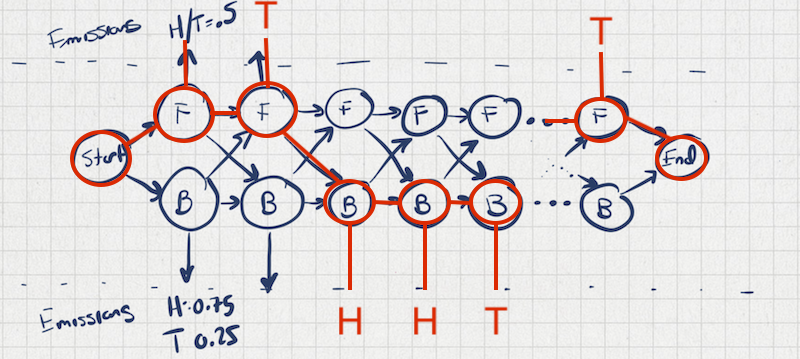

## Other uses of HMMs - 'pair' HMMs for sequence alignment

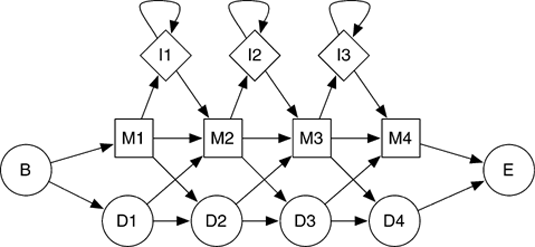

[Source](https://www.google.com/url?sa=i&url=https%3A%2F%2Fbibiserv.cebitec.uni-bielefeld.de%2Fsadr2%2Fdatabasesearch%2Fhmmer%2Findex.html&psig=AOvVaw37AzGUuVYau5ILcC57MbJT&ust=1622253315083000&source=images&cd=vfe&ved=0CAMQjB1qFwoTCIi25Nmi6_ACFQAAAAAdAAAAABAJ)

## Other uses of HMMs - Gene discovery and annotation

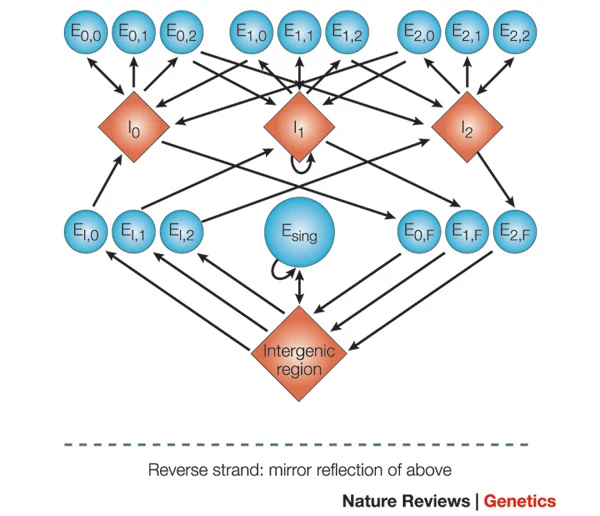

[Source](https://www.nature.com/articles/nrg890?foxtrotcallback=true)

## Beyond HMMs

- Many of the same techniques and approaches are used in machine learning

- How to propagate probabilties, estimate parameters, dynamic programming approaches

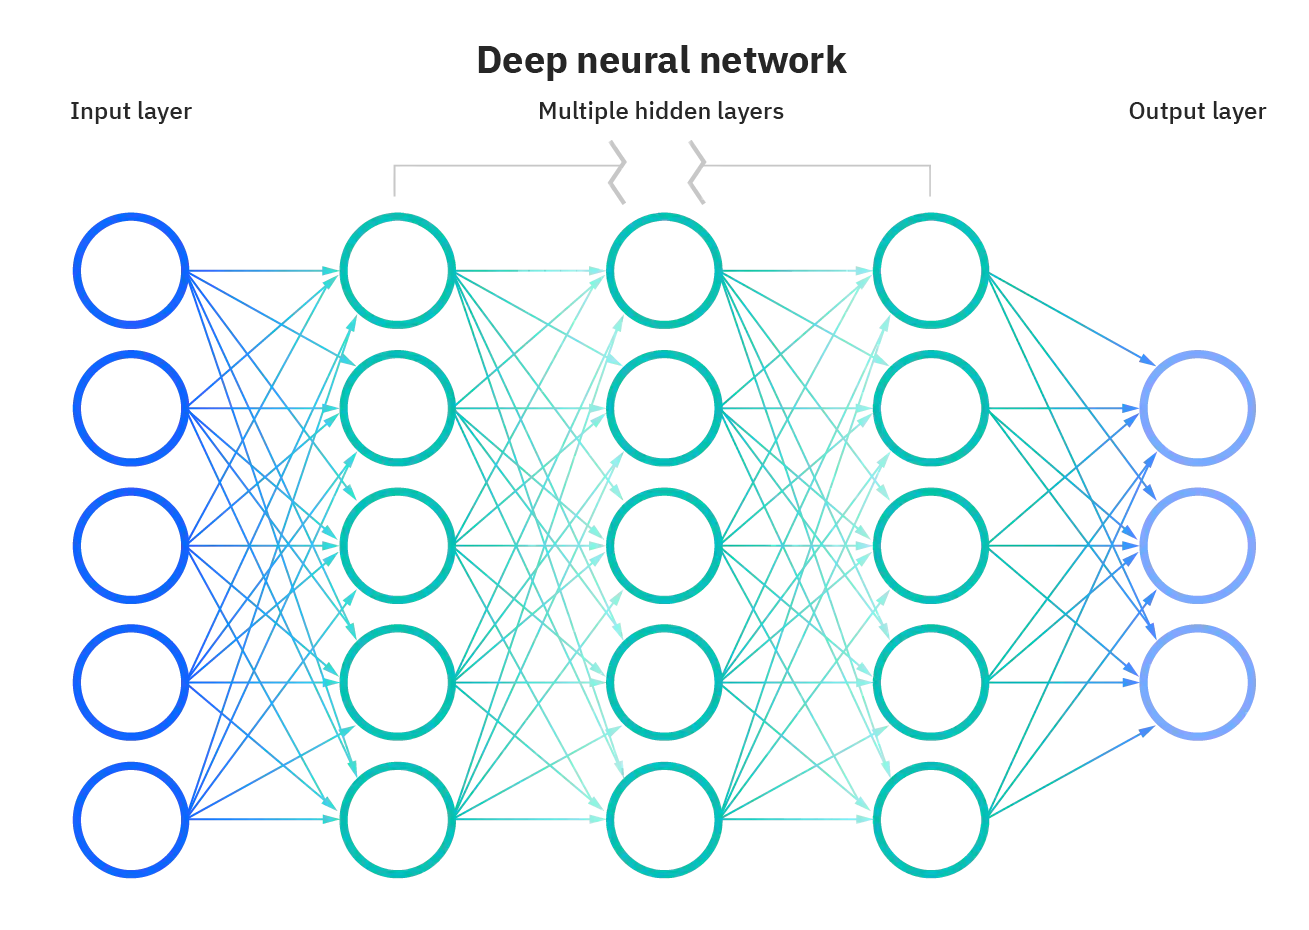
[Source](https://www.ibm.com/cloud/learn/neural-networks)

## Goals for the class

- A three week 'firehose' approach to computational biology with an EM approach:

- Exposure to some python programming in the context of these larger problems

- Constrained solutions to these problems in computational biology to motivate learning python (loop)

- Hopefully enough threads to pull on that you'll be able to trackle your own problems in the future

- Hopefully not a fear of either, though I fear I may how drowned some folks...

- But it's grad school.. again HW6 due Tuesday. Good luck out there!